# It's raining threes in NBA: is it worth it?

## Introduction

In the last years the NBA has changed dramatically. The playstyle is now more oriented toward early three point shot and fast offensive transitions. Many analyst have been wondering if this basketball revolution benefits to the show and helps the team to win the matches. 

The case is of great interest because the NBA (and in general the american sports) is one of the first sports where the data analytics are heavily exploited to increase the efficiency of the teams. The raising of three point shots comes just from the Big Data analysis.

One of the most relevant example is the landing in NBA of Daryl Morey as the General Manager of the Houston Rockets in 2006: his experience in the computer science and statistics world leads to a data driven playstyle. The criticisms were not missing from NBA fans and former players. Nevertheless, data are now used by any NBA team and it is one crucial aspect to take into account to build a winning team.

In our analysis we want to explore the efficiency of the three point shots and asking if there is an ideal amount of threes to maximize the chance of victory. In order to achieve our purposes we build a machine learning model capable to predict the probability to win. Thereafter we adopt our machine learning model to visualize the non-linear dependence between the three point shots attempted and the chance of winning. 

In [1]:
#Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import HTML, Markdown, display
import random

# definition of the functions

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

def Single_column_variation(df = None, column = None, min_value = 0, max_value = 40):
    """This function takes in input a dataframe df and duplicate in a list of dataframe. 
    The new dataframes are built from one row of the original dataframe.
    All the column are fixed, and the column selected range from 0 to max_value."""
    
    df_list = list()

    for i in range(len(df)-1):
        
        df_list.append(pd.DataFrame(df.iloc[i]).transpose())           
        
        df_list[i] = pd.DataFrame(np.repeat(df_list[i].values,
                                  max_value-min_value, axis=0), columns=df_list[i].columns)  # Duplicate each row in a new dataframe
    
     
        for k in range(min_value,max_value):
            df_list[i][column][k] = k    # modify the value of the selected column 

    return df_list


def Best_stats(df, model=None):
    """This function predict the statistics that maximize the probability of winning"""
    
    results = list()
    max_prob = list()

    for i in range(len(df)-1):
        
        results.append(model.predict_proba(df[i])[:,1])  #Predict the probability to win for each value of the selected varying column
        max_prob.append(results[i].argmax())   # Estimate the best stats
        
    return results, max_prob

def printmd(string):
    display(Markdown(string))

hide_toggle()

## Overview of the data

To build our machine learning model we adopt the NBA games dataset available on Kaggle: https://www.kaggle.com/nathanlauga/nba-games

In our model we use 2 dataset:
* games.csv : all games from 2004 season to last update with the date, teams and some details like number of points, etc.
* games_details.csv : details of games dataset, all statistics of players for a given game

From "games.csv" we select the season of each game and merge with the "games_details" dataframe to include in our model the season in which it was played every game. 

From the first approach we immediately see that there are some NaN value, in particular in the "COMMENT" column. Therefore we need to clean our dataset properly before building the model. Here is a brief overlook of our data:

In [2]:
# Read the data
df = pd.read_csv("games_details.csv")
seasons = pd.read_csv("games.csv")[["GAME_ID","SEASON"]]

hide_toggle()

In [3]:
df.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,...,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0
1,42000102,1610612764,WAS,Washington,1629060,Rui Hachimura,F,NaN,25:50,4.0,...,2.0,5.0,7.0,1.0,0.0,0.0,3.0,4.0,11.0,-6.0
2,42000102,1610612764,WAS,Washington,203458,Alex Len,C,NaN,12:11,3.0,...,3.0,2.0,5.0,0.0,1.0,0.0,0.0,2.0,6.0,-11.0
3,42000102,1610612764,WAS,Washington,203526,Raul Neto,G,NaN,19:19,2.0,...,1.0,2.0,3.0,1.0,0.0,0.0,0.0,2.0,4.0,-17.0
4,42000102,1610612764,WAS,Washington,201566,Russell Westbrook,G,NaN,29:07,2.0,...,2.0,4.0,6.0,11.0,0.0,0.0,4.0,0.0,10.0,-16.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615626 entries, 0 to 615625
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            615626 non-null  int64  
 1   TEAM_ID            615626 non-null  int64  
 2   TEAM_ABBREVIATION  615626 non-null  object 
 3   TEAM_CITY          615626 non-null  object 
 4   PLAYER_ID          615626 non-null  int64  
 5   PLAYER_NAME        615626 non-null  object 
 6   START_POSITION     235795 non-null  object 
 7   COMMENT            100048 non-null  object 
 8   MIN                515577 non-null  object 
 9   FGM                515577 non-null  float64
 10  FGA                515577 non-null  float64
 11  FG_PCT             515577 non-null  float64
 12  FG3M               515577 non-null  float64
 13  FG3A               515577 non-null  float64
 14  FG3_PCT            515577 non-null  float64
 15  FTM                515577 non-null  float64
 16  FT

In [5]:
df.drop(["GAME_ID","TEAM_ID","PLAYER_ID"],axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FGM,515577.0,3.575898,3.017828,0.0,1.00,3.000,5.000,28.0
FGA,515577.0,7.879867,5.653108,0.0,3.00,7.000,11.000,50.0
FG_PCT,515577.0,0.415921,0.251533,0.0,0.25,0.429,0.571,1.0
FG3M,515577.0,0.747698,1.200864,0.0,0.00,0.000,1.000,14.0
FG3A,515577.0,2.098759,2.510032,0.0,0.00,1.000,3.000,24.0
FG3_PCT,515577.0,0.196683,0.289237,0.0,0.00,0.000,0.375,1.0
FTM,515577.0,1.744612,2.359994,0.0,0.00,1.000,3.000,26.0
FTA,515577.0,2.302996,2.897069,0.0,0.00,2.000,4.000,39.0
FT_PCT,515577.0,0.437320,0.427660,0.0,0.00,0.500,0.909,1.0
OREB,515577.0,1.030374,1.403506,0.0,0.00,1.000,2.000,18.0


## Data cleaning

In this section we will select the data in which we are interested and detect some anomaly in the dataset. At the end of this section the dataset will be clean suited for an exploratory data analisys and the construction of our machine learning model.

### Duplicated data

The set contain 324 duplicated data; some player stats are repeated more than one time. Once we have identified the duplicate, we dropped them.

In [6]:
df[df.duplicated(subset=["GAME_ID","PLAYER_ID"], keep="first")]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
12942,22000069,1610612763,MEM,Memphis,1628960,Grayson Allen,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12943,22000069,1610612763,MEM,Memphis,1629007,Jontay Porter,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12944,22000069,1610612763,MEM,Memphis,1630214,Xavier Tillman,NaN,DNP - Injury/Illness,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12945,22000069,1610612766,CHA,Charlotte,1630176,Vernon Carey Jr.,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12946,22000069,1610612766,CHA,Charlotte,1628370,Malik Monk,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29827,22000002,1610612747,LAL,Los Angeles,2544,LeBron James,F,NaN,28:21,7.0,...,2.0,3.0,5.0,5.0,0.0,0.0,4.0,2.0,22.0,2.0
29828,22000002,1610612747,LAL,Los Angeles,203484,Kentavious Caldwell-Pope,G,NaN,23:03,2.0,...,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,9.0,-9.0
29829,22000002,1610612747,LAL,Los Angeles,203471,Dennis Schroder,G,NaN,27:48,5.0,...,1.0,11.0,12.0,8.0,0.0,0.0,1.0,4.0,14.0,-10.0
29830,22000002,1610612747,LAL,Los Angeles,1628398,Kyle Kuzma,NaN,NaN,26:38,6.0,...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,15.0,1.0


In [7]:
df.drop_duplicates(subset=["GAME_ID","PLAYER_ID"],keep="first",inplace=True)

### Group the statistics for game

We are interested in the statistics for each NBA game. Therefore, we group and sum the statistics of every player for a fixed game. After that, some statistics like the player_id, the plus minus and the shot percentages lose meaning, so we drop it and, in the case of the shot percentages, we recalculate them. With this process, we lose some NaN values and some columns in which we are not interested.

In [8]:
df = df.groupby(["GAME_ID","TEAM_ID"]).sum()
df = df.reset_index()
df = df.drop(['PLAYER_ID', 'FG_PCT','FG3_PCT','FT_PCT','PLUS_MINUS'],axis=1)

df["FG_PCT"] = df["FGM"]/df["FGA"]*100
df["FG3_PCT"] = df["FG3M"]/df["FG3A"]*100
df["FT_PCT"] = df["FTM"]/df["FTA"]*100

hide_toggle()

### Null values and anomalous data

The new columns show one of the anomaly of our dataset. We have a row in which the percentages are null, due to 0 shot attempts in a game. We can easily detect that the game with the ID = 10500109 has three unique rows. Obviously it is impossible that three team are involved in a single match. The suspicious game has one of the row with all zeros; it is clearly an error in the composition of the dataset, therefore we can eliminate from our set.

In [33]:
hide_toggle(for_next=True)

In [10]:
print (f"There is still {df.isna().sum().sum()} null values.\n")
print ("There is a game with 3 unique rows.\n")

print(df["GAME_ID"].value_counts().sort_values().tail(5))

display(df[df["GAME_ID"] == 10500109])

#dropping the null row

df = df.drop(index=335,axis=0)
df = df.reset_index().drop("index",axis=1)


There is still 3 null values.

There is a game with 3 unique rows.

21901318    2
20701212    2
21000334    2
21800981    2
10500109    3
Name: GAME_ID, dtype: int64


,GAME_ID,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT
334,10500109,1610612742,36.0,73.0,5.0,16.0,26.0,35.0,10.0,27.0,37.0,18.0,8.0,9.0,13.0,19.0,103.0,49.315068,31.250000,74.285714
335,10500109,1610612756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
336,10500109,1610612765,40.0,87.0,4.0,9.0,13.0,15.0,15.0,26.0,41.0,20.0,7.0,11.0,13.0,29.0,97.0,45.977011,44.444444,86.666667


In order to introduce the feature "Victory", we run a check of possible "tie game" (the code will be used again in the next section). In indicates some error in the computation of the points, because a tie at the end of the fourth quarter would be resolved in the overtime (the dataset take into account this scenario). This happens because some player stats record are missing. After a manual cross check with the games.csv set, we fixed the error.

In [11]:
df.loc[7002, "PTS"] = 90
df.loc[7623,"PTS"] = 103 

hide_toggle()

### Victory label

In order to train our machine learning model to estimate the chance of victory of a team based on some of its statistics, we introduce the "VICTORY" label, calculated checking the points made from the two teams in a fixed game.

In [34]:
hide_toggle(for_next=True)

In [13]:
df = df.sort_values("GAME_ID")   #Sort the rows by GAME_ID, it is an extra check to avoid any bug in the next rows of the code
df["VICTORY"] = ""

for i in range(0,len(df)-1,2):
    if df["PTS"][i] > df["PTS"][i+1]:   # Check which of the two team has won and update the "VICTORY" column
        
        df.loc[i , "VICTORY"] = "Yes"
        df.loc[i+1 , "VICTORY"] = "No"
        
    elif df["PTS"][i] < df["PTS"][i+1]:
        
        df.loc[i , "VICTORY"] = "No"
        df.loc[i+1 , "VICTORY"] = "Yes"  
        
    else:                               # Check for eventual problematic rows
        print("Tie game?")
        print(df.iloc[i])

Now we add to the dataframe the season label, in order to explore the evolution of the stars over the last years. At this point the dataset is clean and ready to be explored.

In [14]:
df = pd.merge(df,seasons,how="left",on="GAME_ID")

In [15]:
df.head()

,GAME_ID,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,...,STL,BLK,TO,PF,PTS,FG_PCT,FG3_PCT,FT_PCT,VICTORY,SEASON
0,10300001,1610612742,34.0,76.0,2.0,8.0,15.0,30.0,12.0,26.0,...,9.0,4.0,18.0,34.0,85.0,44.736842,25.000000,50.000000,No,2003
1,10300001,1610612762,32.0,70.0,1.0,7.0,25.0,34.0,9.0,32.0,...,8.0,4.0,18.0,26.0,90.0,45.714286,14.285714,73.529412,Yes,2003
2,10300002,1610612749,32.0,75.0,2.0,13.0,28.0,40.0,11.0,32.0,...,9.0,4.0,24.0,26.0,94.0,42.666667,15.384615,70.000000,No,2003
3,10300002,1610612763,40.0,81.0,4.0,15.0,21.0,34.0,14.0,34.0,...,18.0,7.0,25.0,35.0,105.0,49.382716,26.666667,61.764706,Yes,2003
4,10300003,1610612739,38.0,77.0,4.0,6.0,20.0,29.0,12.0,40.0,...,10.0,7.0,25.0,33.0,100.0,49.350649,66.666667,68.965517,Yes,2003


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49156 entries, 0 to 49155
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GAME_ID  49156 non-null  int64  
 1   TEAM_ID  49156 non-null  int64  
 2   FGM      49156 non-null  float64
 3   FGA      49156 non-null  float64
 4   FG3M     49156 non-null  float64
 5   FG3A     49156 non-null  float64
 6   FTM      49156 non-null  float64
 7   FTA      49156 non-null  float64
 8   OREB     49156 non-null  float64
 9   DREB     49156 non-null  float64
 10  REB      49156 non-null  float64
 11  AST      49156 non-null  float64
 12  STL      49156 non-null  float64
 13  BLK      49156 non-null  float64
 14  TO       49156 non-null  float64
 15  PF       49156 non-null  float64
 16  PTS      49156 non-null  float64
 17  FG_PCT   49156 non-null  float64
 18  FG3_PCT  49156 non-null  float64
 19  FT_PCT   49156 non-null  float64
 20  VICTORY  49156 non-null  object 
 21  SEASON   491

# Exploratory Data Analysis

As mentioned earlied, we want to focus on the offensive side of the NBA game, with particular attention to the role of the three point shots in the playstyle of NBA teams. 

Here we have the mean of the three point shots per game attempted from the 2003 to the 2020. The trend is constantly increasing from 2012. We have shifted from 15 threes per game in 2003 to 35 threes attempted per game in 2020. That's correspond to an increase of over 200% in less than 20 years. 

Therefore, the hypothesis of a more and more central role of this aspect of the game is confirmed, but how this influence on the win? The figure shows slight difference between the three attempted for the winning and the losing team.

In [35]:
hide_toggle(for_next=True)

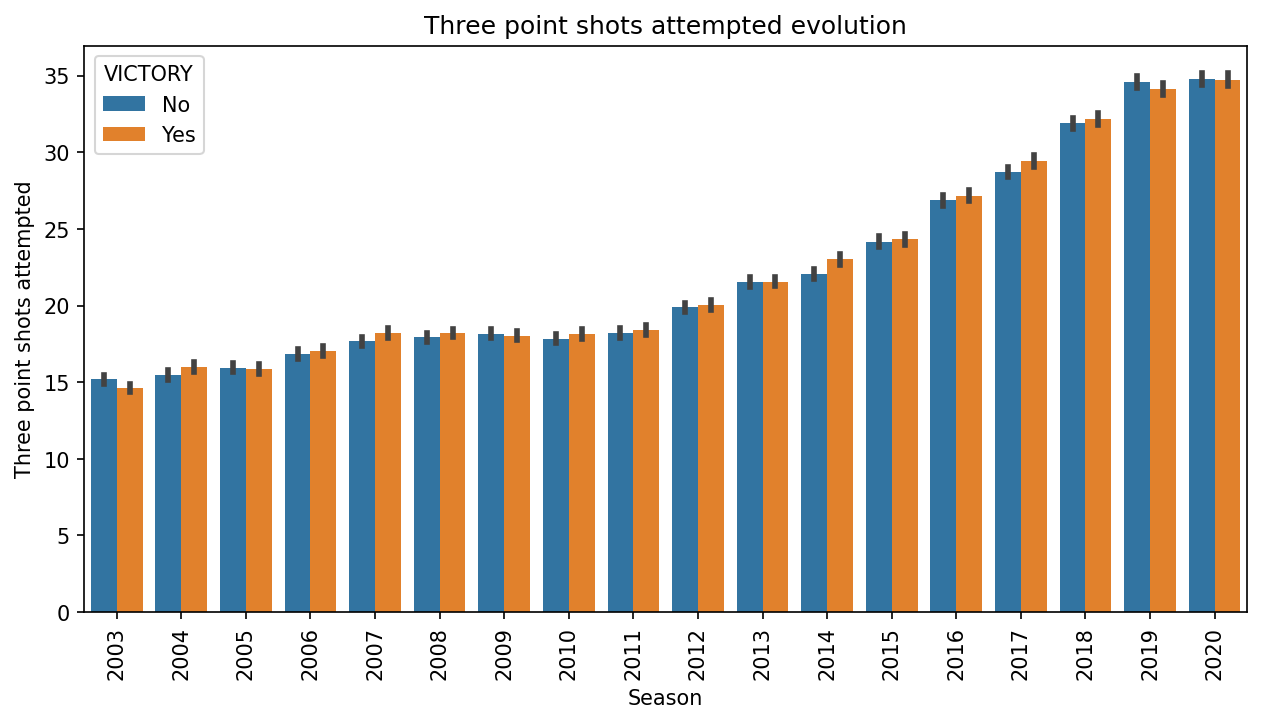

In [18]:
plt.figure(figsize=(10,5),dpi=150)
ax = sns.barplot(data=df,x="SEASON",y="FG3A",hue="VICTORY")

ax.set(ylabel="Three point shots attempted", xlabel="Season")
ax.set_title("Three point shots attempted evolution")

plt.xticks(rotation=90);

With the growth of threes attempted, let's see the percentages evolution over the years. As we can see in the figure below, despite the increasing threes attempted, the average of the threes percentages remains the same around 30-35%. This emphasizes the efficiency of the actual NBA player, capable to maintain optimal percentages even if the volume of long distance shots is larger every year.

Furthermore, the figure suggests an interesting result. As opposed to the previous figure, the percentages are a strong indicator of the success of a team: the average pergentages for a losing or a winning team differs by at least 5%. We have the first crucial indication of the offensive aspect of the game: an efficient offense with high percentages increase the performance of a team.  

In [36]:
hide_toggle(for_next=True)

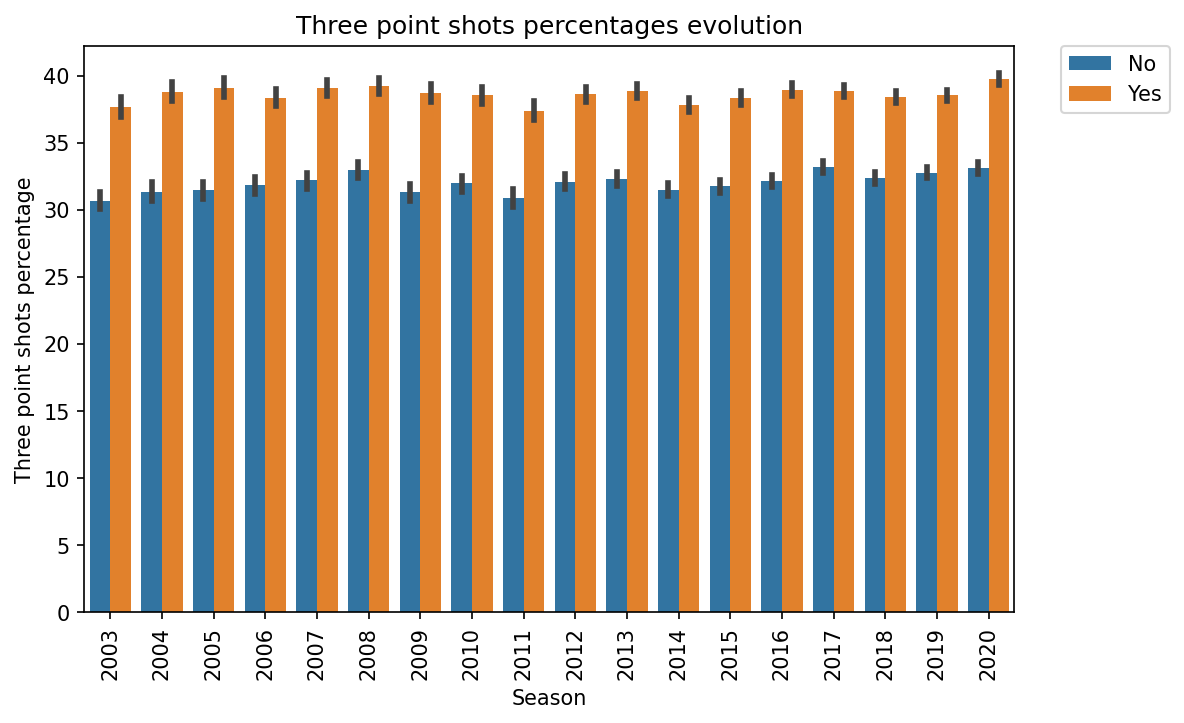

In [20]:
plt.figure(figsize=(8,5),dpi=150)
ax = sns.barplot(data=df,x="SEASON",y="FG3_PCT",hue="VICTORY")

ax.set(ylabel="Three point shots percentage", xlabel="Season")
ax.set_title("Three point shots percentages evolution")
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.xticks(rotation=90);

At this point we may ask how are related the increasing shots with the efficiency of the teams. Faster action, rapid offensive transition and a growing number of offensive solutions in the first seconds could affect the percentages?

In the scatterplot below we see how for threes the increase of the attempts reduce the variance in the percentages: with few shots (0-10) a team could achieve any percentages, istead with a large amount of threes (50-60) the percentages are all in a range between 30% to 50%.

We obtain a similar relation if we consider the field goal (two point shots + three point shots), but in this case the variance in the percentages is greater even for larger amount of shots.

In [37]:
hide_toggle(for_next=True)

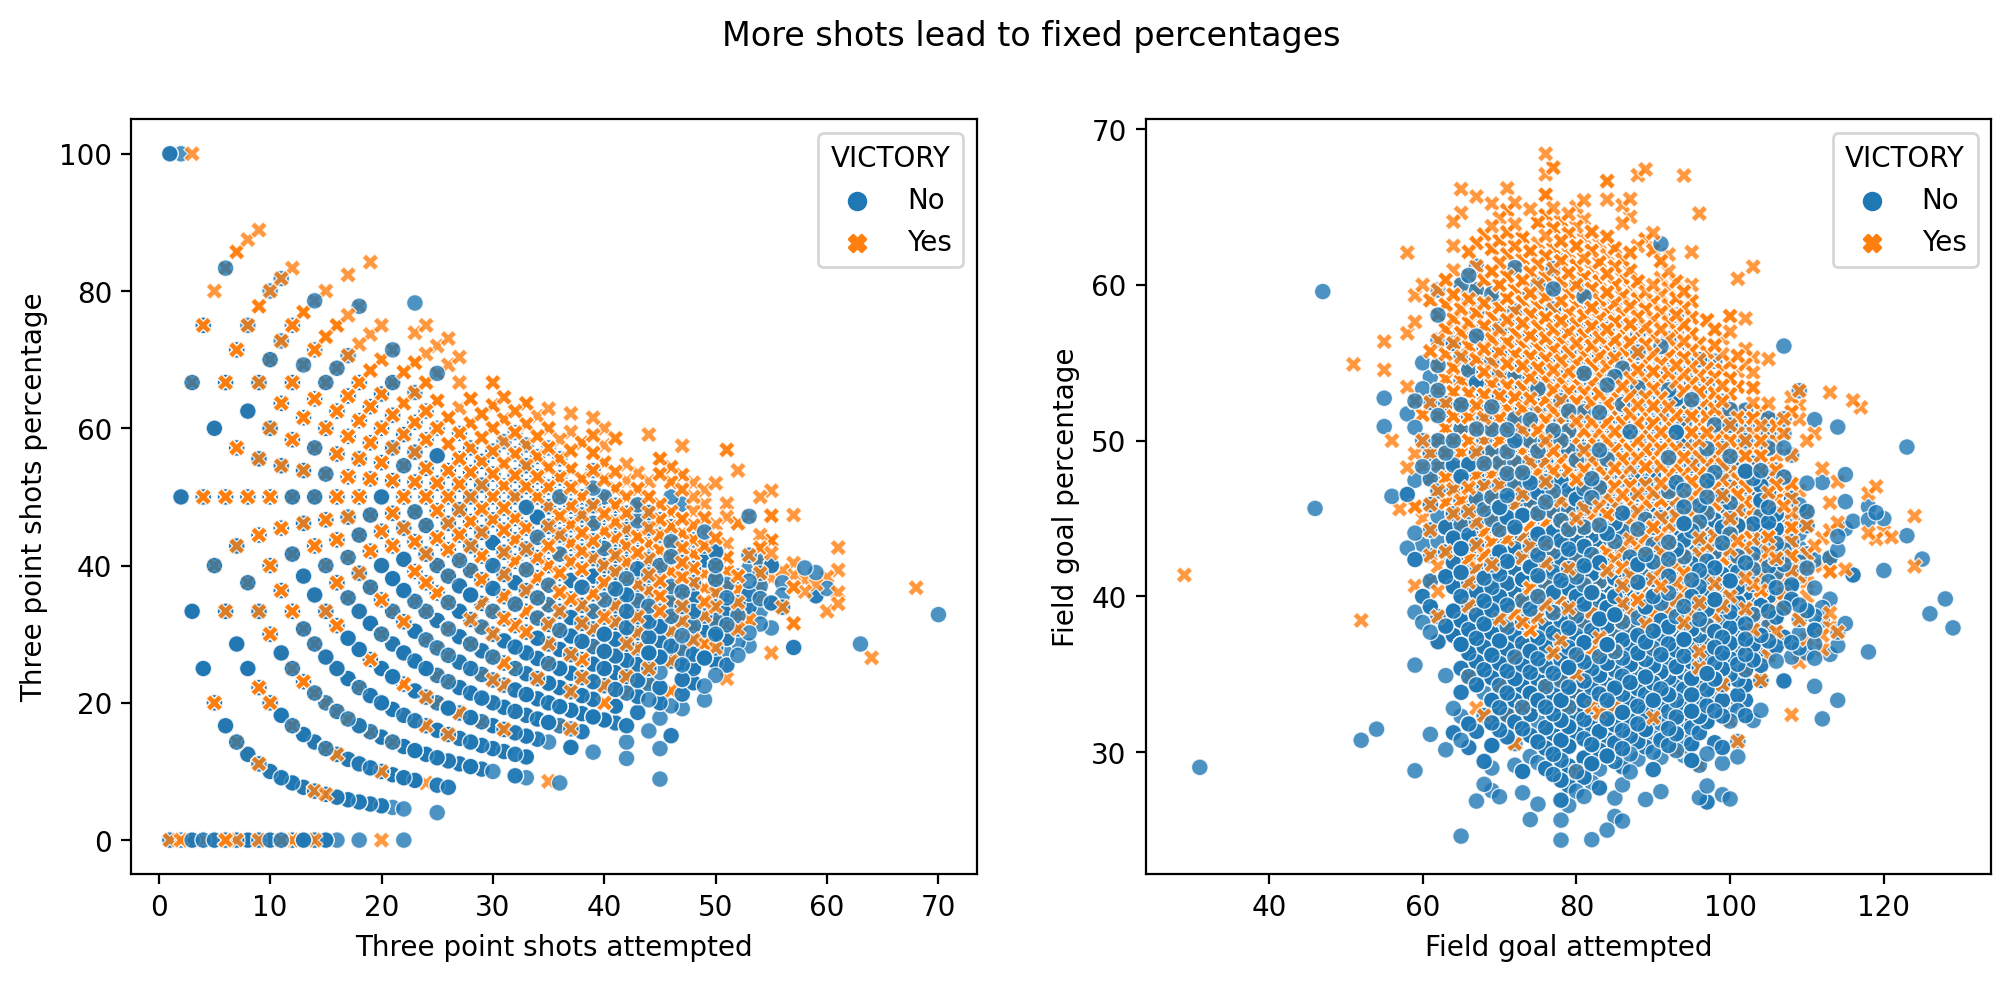

In [22]:
fig, ax = plt.subplots(1,2,figsize=(12,5),dpi=200)

plt.suptitle("More shots lead to fixed percentages")

sns.scatterplot(ax = ax[0],data=df,x="FG3A",y="FG3_PCT",hue="VICTORY",style="VICTORY",alpha=0.8)
ax[0].set(ylabel="Three point shots percentage", xlabel="Three point shots attempted")

sns.scatterplot(ax = ax[1],data=df,x="FGA",y="FG_PCT",hue="VICTORY",style="VICTORY",alpha=0.8) 
ax[1].set(ylabel="Field goal percentage", xlabel="Field goal attempted")

plt.show()

We see that the NBA teams have managed to perform more threes keeping good shot percentages. Let's now compare the amount of shots with the points made during a game. Obviously the points are the key factor that leads to the win, so this could suggests the effectiveness of this new playstyle.

There is a linear relationship between the shot attempted and the points made, either by two or three point shots, but we cannot clearly see if they are correlated with the victory.

In [38]:
hide_toggle(for_next=True)

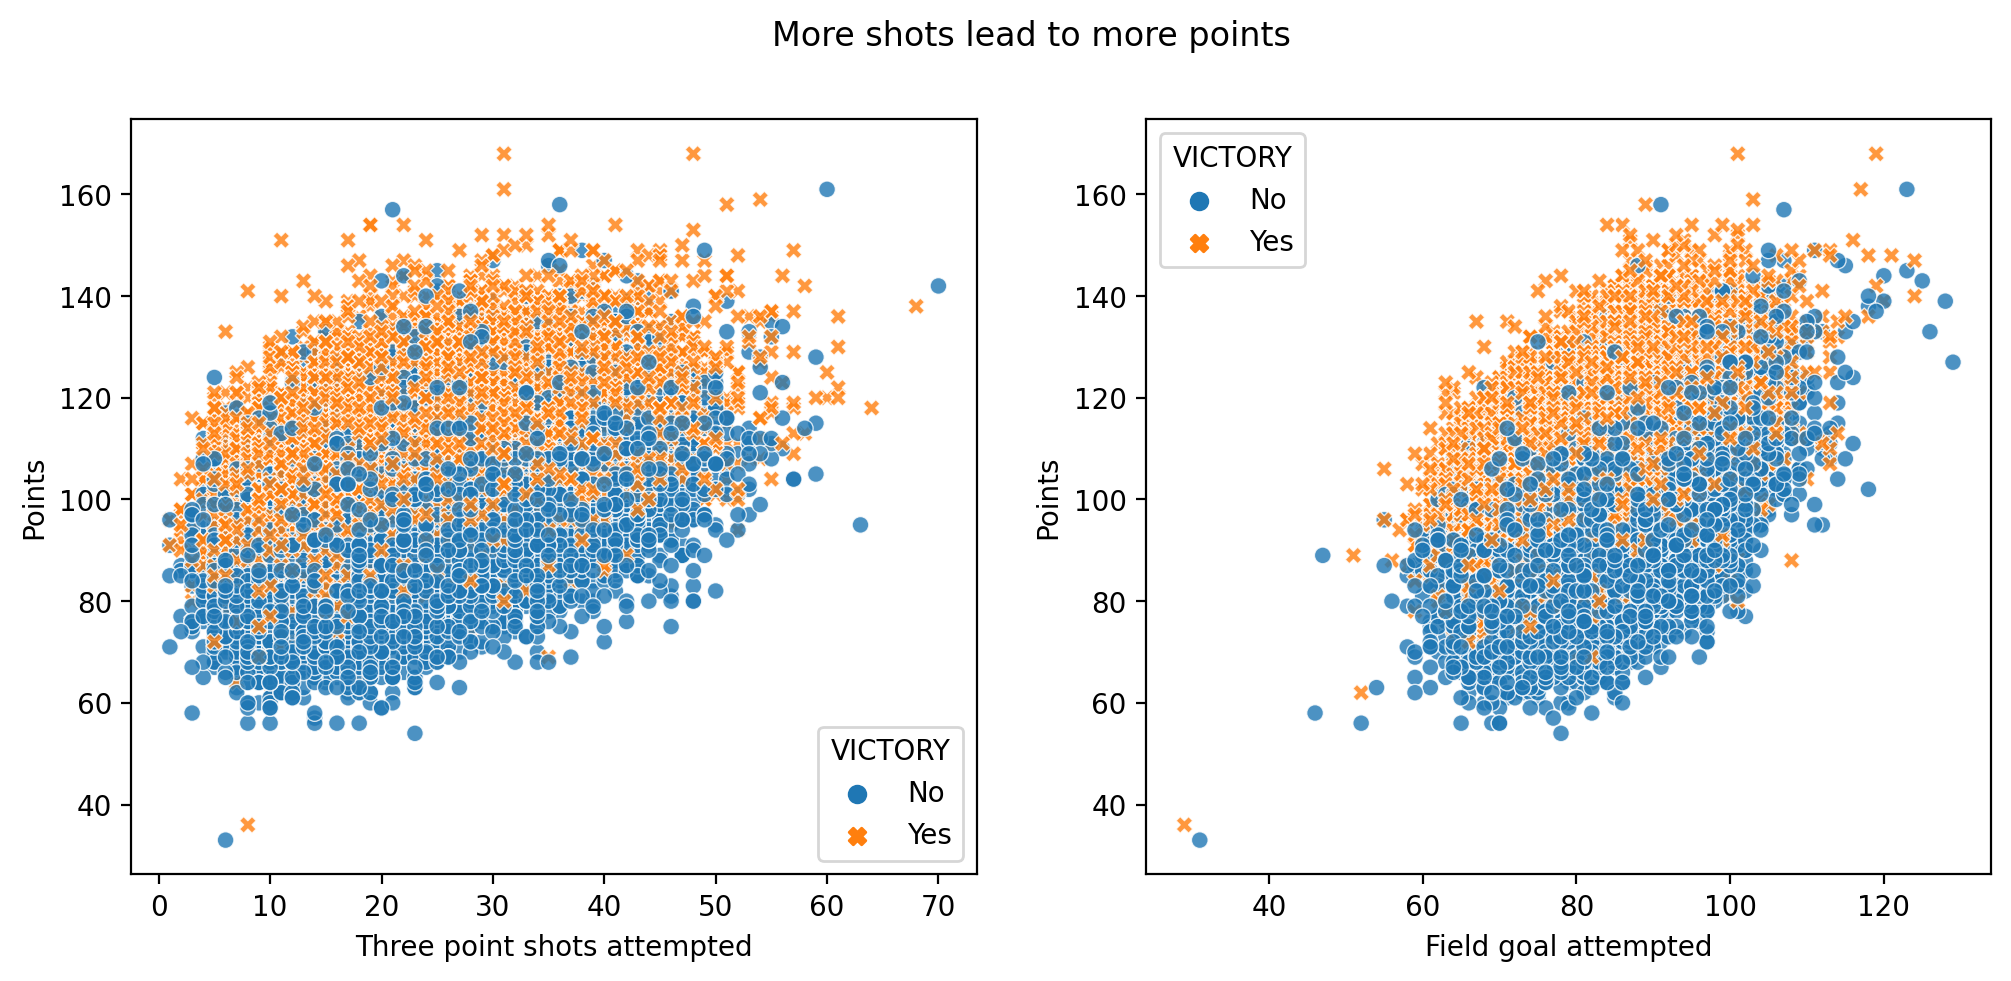

In [24]:
fig, ax = plt.subplots(1,2,figsize=(12,5), dpi=200)

plt.suptitle("More shots lead to more points")

sns.scatterplot(ax = ax[0], data = df, y = "PTS", x = "FG3A", hue = "VICTORY",style="VICTORY",alpha=0.8)
ax[0].set(xlabel="Three point shots attempted", ylabel="Points")

sns.scatterplot(ax = ax[1], data=df, y="PTS", x="FGA", hue="VICTORY",style="VICTORY",alpha=0.8)
ax[1].set(xlabel="Field goal attempted", ylabel="Points")

plt.show()

## Machine Learning model

We decide to build three different machine learning model splitting the data in three different epochs:
1. From 2003 to 2006
2. From 2007 to 2015
3. From 2016 to 2020

We select 2006 and 2017 as turning point in the NBA history. The first is the year during which Daryl Morey became the General Manager of the Houston Rockets. As we already said the impact of Daryl Morey on the playstyle, leading to a datadriven NBA, was huge, influencing all the other teams in the following years. The second  is the year of the consacration of Stephen Curry with the second MVP of the regular season and the astonishing record of its Golden State Warriors with 73 wins in the regular season (it is the most winning regular season ever). This player is one of the greatest three point shooter of all time and has been a great influence on the future generations of players. 

<table><tr>
<td> <img src="Daryl_morey.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="Steph_curry.jpg" alt="Drawing" style="width: 450px;"/> </td>
</tr></table>


Having three models we can have a better description of three different phases without losing in accuracy. 

We adopt a Random Forest Classifier selecting the following features:
* Field goals attempted per game
* Three point shots attempted per game
* Free throws attempted per game
* Field goals percentage per game
* Three point shots percentage per game
* Free throws percentage per game
* Offensive rebounds per game
* Defensive rebounds per game
* Assists per game
* Steels per game
* Blocks per game
* Turnovers per game
* Fouls per game

We decided to drop the amount of field goal made, three point made and points; nevertheless there three features are the most important to be fed in a machine learning model in order to predict the results of a game, we need that these stats are not constrain the prediction. The reason will be clearer in the next section.

In [25]:
# Divide the data in three parts

first_split = df[df["SEASON"] < 2007]
second_split = df[(df["SEASON"] >= 2007) & (df["SEASON"] < 2016)]
third_split = df[df["SEASON"] >= 2016]

# ML model for the first chunk of data (2003-2012)

    #Split

X1 = first_split.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y1 = first_split["VICTORY"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=27)

    #Train

model_first_split = RandomForestClassifier(bootstrap=True)
model_first_split.fit(X1_train,y1_train)

    #Predict

y1_pred = model_first_split.predict(X1_test)

# ML model for the second chunk of data (2012-2016)
    
    #Split
    
X2 = second_split.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y2 = second_split["VICTORY"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=27)

    #Train

model_second_split = RandomForestClassifier(bootstrap=True)
model_second_split.fit(X2_train,y2_train)

    #Predict

y2_pred = model_second_split.predict(X2_test)

# ML model for the third chunk of data (2016-2020)

    #Split

X3 = third_split.drop(["SEASON","VICTORY","FGM","FTM","FG3M","PTS","GAME_ID","TEAM_ID","REB"],axis=1)
y3 = third_split["VICTORY"]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=27)

    #Train

model_third_split = RandomForestClassifier(bootstrap=True)
model_third_split.fit(X3_train,y3_train)

    #Predict

y3_pred = model_third_split.predict(X3_test)

hide_toggle()

In [40]:
printmd("These are the results for the first model (2003-2006)\n")
print(classification_report(y1_test,y1_pred))

printmd("These are the results for the second model (2007-2015)\n")
print(classification_report(y2_test,y2_pred))

printmd("These are the results for the first model (2016-2020)\n")
print(classification_report(y3_test,y3_pred))

hide_toggle()

These are the results for the first model (2003-2006)


              precision    recall  f1-score   support

          No       0.80      0.82      0.81      1685
         Yes       0.81      0.79      0.80      1615

    accuracy                           0.81      3300
   macro avg       0.81      0.81      0.81      3300
weighted avg       0.81      0.81      0.81      3300



These are the results for the second model (2007-2015)


              precision    recall  f1-score   support

          No       0.81      0.82      0.81      3791
         Yes       0.81      0.80      0.81      3690

    accuracy                           0.81      7481
   macro avg       0.81      0.81      0.81      7481
weighted avg       0.81      0.81      0.81      7481



These are the results for the first model (2016-2020)


              precision    recall  f1-score   support

          No       0.80      0.81      0.81      1937
         Yes       0.82      0.80      0.81      2031

    accuracy                           0.81      3968
   macro avg       0.81      0.81      0.81      3968
weighted avg       0.81      0.81      0.81      3968



## Partial Derivation Plots

Our models predict the victory of a team with an accuracy of 81%. We are satisfied with this accuracy: the outcome of a match depends also on the performance of the adversary, moreover we are not interested in the prediction of winning for a team, but we want to explore the non-linear dependences between the feaures and the label.

We build Partial Derivation Plots (PDP) to represent the relation between the chance to win and the three point shots attempted; for every row of the test dataset (we don't want leakage from the train dataset) we select a single column (in this case the three point shots attempted per game) varying in a range between 0 and 60 and create a new dataframe keeping all the other features constant. By averaging for all the games, we obtain the PDPs.

If we haven't drop from our model field goal made, three point made and points, varying the threes these stats, that are intrisically interacting with each other, lose any sense. In this way we lose in accuracy in the prediction, but we maintain the sense of the model during the partial derivation.

In [27]:
first_split_list = Single_column_variation(X1_test,"FG3A",0,60)
results_first_split, max_prob_first_split = Best_stats(first_split_list, model_first_split)

second_split_list = Single_column_variation(X2_test,"FG3A",0,60)
results_second_split, max_prob_second_split = Best_stats(second_split_list, model_second_split)

third_split_list = Single_column_variation(X3_test,"FG3A",0,60)
results_third_split, max_prob_third_split = Best_stats(third_split_list, model_third_split)

hide_toggle()

The figure below shows the change in the NBA playstyle. For the set between 2003-2006 the relation follows a parabola, with the maximum around 20 threes and a minimum after 40 threes. The set between 2007-2015 shows an almost linear relation with the chance increasing with more threes until the plateau present after 45 threes. The set between 2016-2020 shows that the chance to win are strongly dependent on the threes attempted.

In [28]:
hide_toggle(for_next=True)

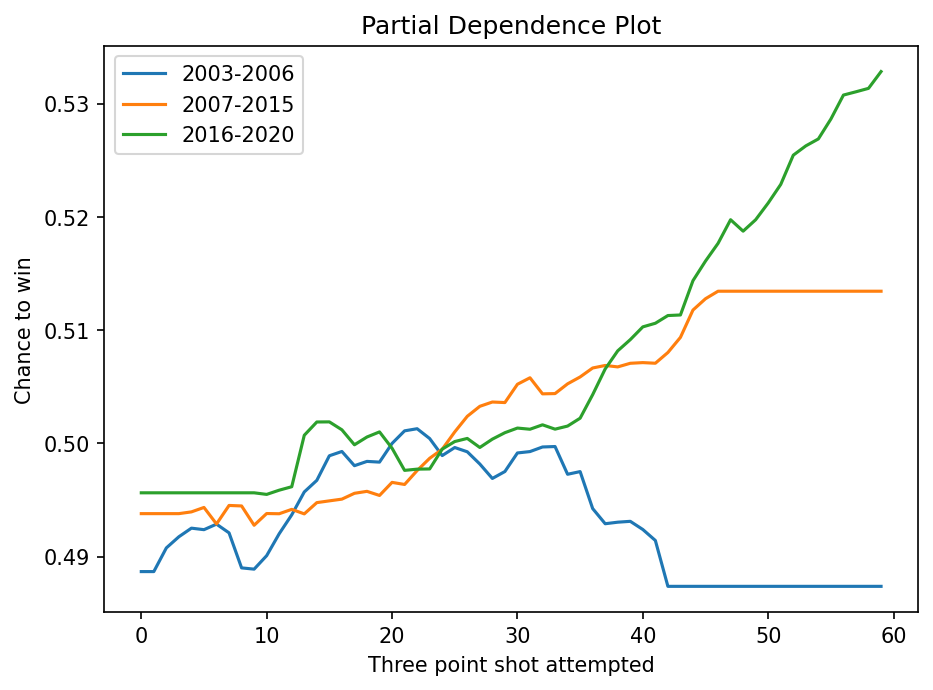

In [29]:
average1 = np.sum(results_first_split,axis=0)/len(results_first_split)
average2 = np.sum(results_second_split,axis=0)/len(results_second_split)
average3 = np.sum(results_third_split,axis=0)/len(results_third_split)

plt.figure(figsize=(7,5),dpi=150)

plt.plot(range(60),average1)
plt.plot(range(60),average2)
plt.plot(range(60),average3)

plt.legend(["2003-2006","2007-2015","2016-2020"])
plt.xlabel("Three point shot attempted")
plt.ylabel("Chance to win") 
plt.title("Partial Dependence Plot")

plt.show()

## Estimation of the ideal amount of three point shots

Selecting the number of threes that maximize the chance to win, we can obtain their distribution. Following our model we observe that in certain games, attempting three point shots lowers the chance to win, therefore we have a significance amount of game with 0 as the ideal amount of three point shots. 

Moreover, the peak in the distributions goes to large number of attempts during the years, confirming the increasingly importance of this aspect of the game. 

In [30]:
hide_toggle(for_next=True)

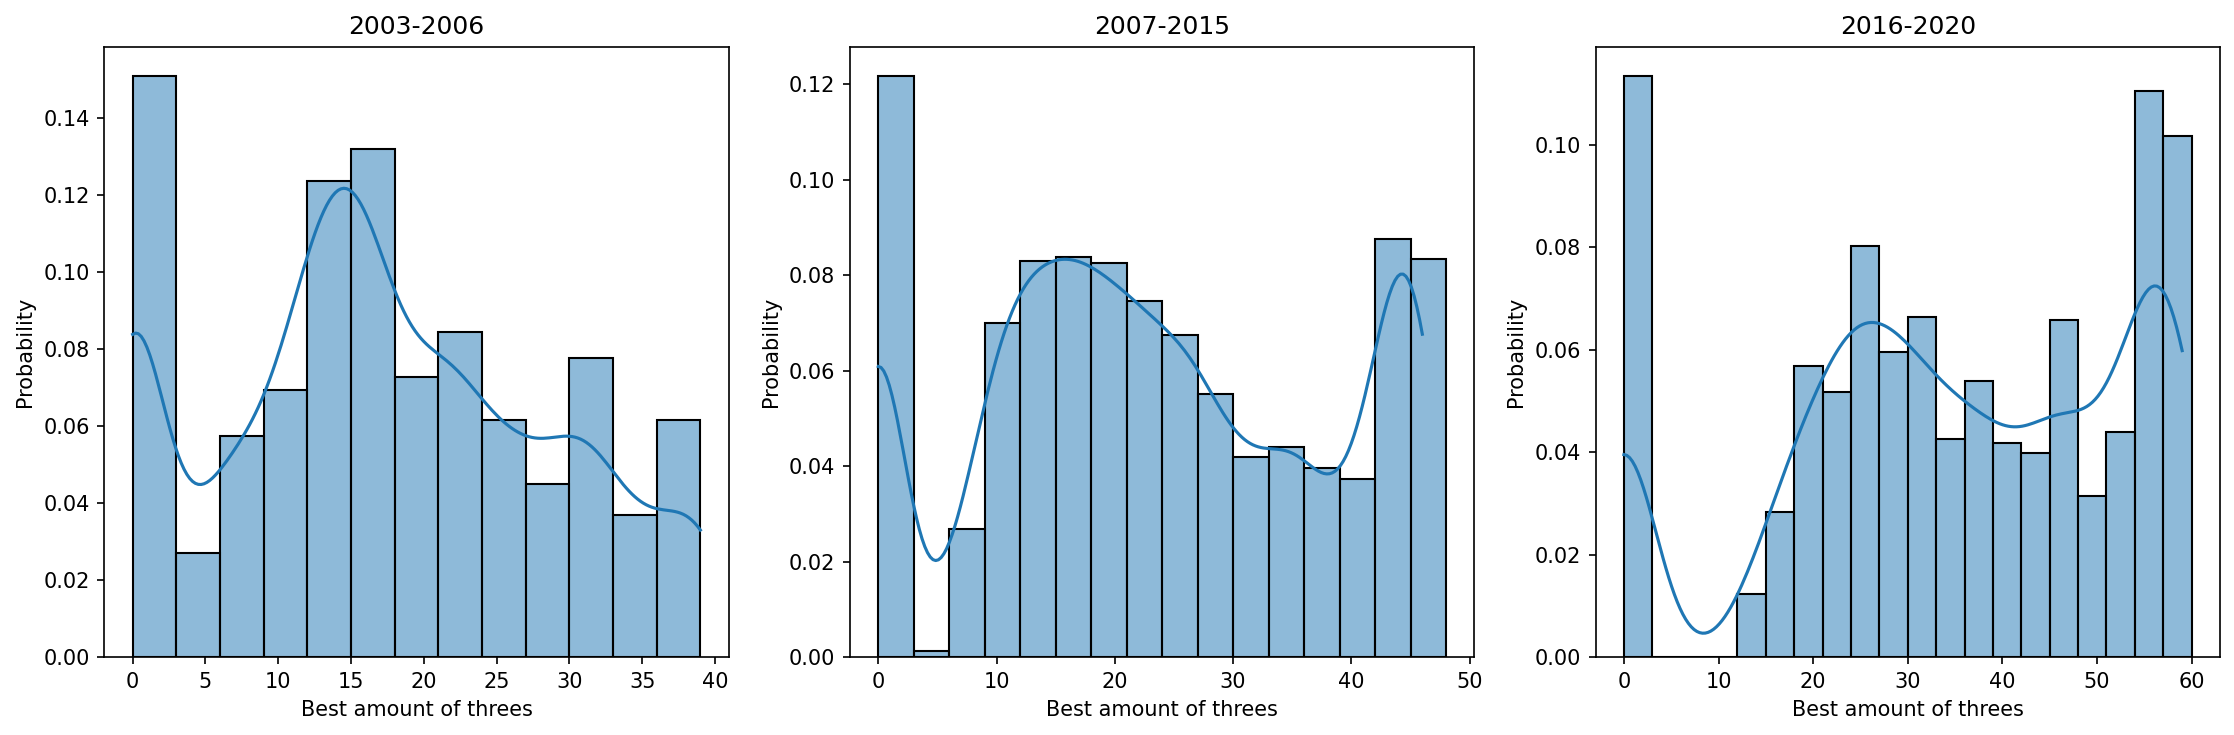

In [31]:
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=150)

sns.histplot(ax = ax[0], x = max_prob_first_split, kde=True, stat="probability", binwidth=3)
ax[0].set(xlabel="Best amount of threes", title="2003-2006")

sns.histplot(ax = ax[1], x = max_prob_second_split, kde=True, stat="probability", binwidth=3)
ax[1].set(xlabel="Best amount of threes", title="2007-2015")

sns.histplot(ax = ax[2], x = max_prob_third_split, kde=True, stat="probability", binwidth=3)
ax[2].set(xlabel="Best amount of threes", title="2016-2020")

plt.tight_layout()
plt.show()

## Which playstyle is the best?

We conclude the analysis with a fun challenge. Despite the range of the statistics isn't differ to much between the three periods, this model isn't 100% affordable. So take this last section lightly. 

In this section we predict the victory or defeat of the teams, but adopting the old model (2003-2006) for the modern team (2016-2020) and viceversa. The games are equally distributed between victories and defeats. We observe that the win rates lower to 38% for the old team playing in the modern NBA and raises to 63% for the modern team playing in the old NBA. 

In [32]:
old_school_pred = model_third_split.predict_proba(X1)
new_school_pred = model_first_split.predict_proba(X3)

lose_mean_old = old_school_pred.mean(axis=0)[0]
win_mean_old = old_school_pred.mean(axis=0)[1]
lose_mean_new = new_school_pred.mean(axis=0)[0]
win_mean_new = new_school_pred.mean(axis=0)[1]

print("Old style team playing in the modern NBA win rate  =", win_mean_old,
     "\nNew style team playin in the past NBA win rate =", win_mean_new)

hide_toggle()

Old style team playing in the modern NBA win rate  = 0.37843426077468534 
New style team playin in the past NBA win rate = 0.6226799758015714
